In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Flatten, Dropout, Reshape, LayerNormalization, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt


In [2]:
#HYPERPARAMETERS
BATCH_SIZE=64
EPOCHS=100
NUM_CLASSES=7

In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


NEURAL NET

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LayerNormalization
from spektral.layers import GATConv

def build_gat_model(num_classes, num_nodes, num_features):
    node_input = Input(shape=(num_nodes, num_features), name="Node_Features")
    adj_input = Input(shape=(num_nodes, num_nodes), name="Adjacency_Matrix")

    # Graph Attention Layers
    x = GATConv(128, attn_heads=8, concat=False, activation='relu')([node_input, adj_input])
    x = LayerNormalization()(x)  # Normalize to stabilize learning
    x = Dropout(0.3)(x)

    x = GATConv(128, attn_heads=8, concat=False, activation='relu')([x, adj_input])
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = GATConv(64, attn_heads=8, concat=False, activation='relu')([x, adj_input])
    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[node_input, adj_input], outputs=out)
    return model

# Build the improved model



In [4]:
# Load the .npy files
ab_columns = np.load("ab_columns.npy", allow_pickle=True)
coh_columns = np.load("coh_columns.npy", allow_pickle=True)
other_columns = np.load("other_columns.npy", allow_pickle=True)

# Print the loaded data
print("ab_columns:", ab_columns)
print("coh_columns:", coh_columns)
print("other_columns:", other_columns)


ab_columns: [[48.84389  46.533704 25.924618 ...  2.388181  4.271034  4.093793]
 [34.108015 22.838567 20.646824 ...  2.507125  1.333279  7.415794]
 [31.084064 28.212342 30.467865 ...  6.313069  2.739807  7.6445  ]
 ...
 [20.05537  11.734445 15.719485 ...  1.180694  1.100077  0.741887]
 [26.43057  20.721589 25.486586 ...  0.976765  1.362347  1.168174]
 [14.64494  14.570681 13.731359 ...  0.442399  0.300771  0.411511]]
coh_columns: [[85.05668  84.314205 88.042424 ... 30.893891 74.038603 51.237679]
 [84.994328 57.571481 75.298051 ... 40.297206 55.547526 63.630547]
 [43.406463 33.374232 37.783015 ... 53.49483  66.581021 80.202968]
 ...
 [59.618728 56.295958 73.067333 ... 62.032961 79.282698 80.363086]
 [73.70224  56.132581 67.605944 ... 27.534399 40.861627 49.097135]
 [82.495367 53.115312 71.716848 ... 43.366516 59.321302 51.526134]]
other_columns: [[1 'F' 31.55 ... 103.0 'Mood disorder' 'Depressive disorder']
 [2 'M' 25.0 ... 115.0 'Healthy control' 'Healthy control']
 [3 'M' 26.2 ... 83.0

In [5]:
# Define EEG 10-20 electrode locations (simplified)
eeg_electrodes = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

# Define predefined connections based on 10-20 system
connections = [
    ("Fp1", "F3"), ("Fp2", "F4"), ("F3", "C3"), ("F4", "C4"),
    ("C3", "P3"), ("C4", "P4"), ("P3", "O1"), ("P4", "O2"),
    ("F7", "T3"), ("F8", "T4"), ("T3", "T5"), ("T4", "T6"),
    ("T5", "O1"), ("T6", "O2"), ("Fz", "Cz"), ("Cz", "Pz"),
    ("Fp1", "Fp2"), ("F3", "F4"), ("C3", "C4"), ("P3", "P4"),
    ("O1", "O2"), ("T3", "T4"), ("T5", "T6")
]

# Create adjacency matrix
num_nodes = len(eeg_electrodes)
A = np.zeros((num_nodes, num_nodes))

# Populate adjacency matrix
for (e1, e2) in connections:
    i, j = eeg_electrodes.index(e1), eeg_electrodes.index(e2)
    A[i, j] = A[j, i] = 1  # Symmetric adjacency matrix

In [6]:
labels = other_columns[:, 6]
X_train, X_val, y_train, y_val = train_test_split(coh_columns, labels, test_size=0.2, random_state=42, stratify=labels)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (681, 1026)
X_val shape: (171, 1026)
y_train shape: (681,)
y_val shape: (171,)


In [7]:
# Reshape X_train and X_val to be (samples, EEG nodes, features per node)
num_electrodes = 19  # EEG 10-20 system has 19 standard electrodes
features_per_electrode = X_train.shape[1] // num_electrodes  # Assuming 1026 features evenly distributed

X_train = X_train.reshape(-1, num_electrodes, features_per_electrode)
X_val = X_val.reshape(-1, num_electrodes, features_per_electrode)

# Print new shapes
print("New X_train shape:", X_train.shape)  # Expected: (681, 19, num_features_per_node)
print("New X_val shape:", X_val.shape)      # Expected: (171, 19, num_features_per_node)


New X_train shape: (681, 19, 54)
New X_val shape: (171, 19, 54)


In [8]:
# Duplicate adjacency matrix for all training and validation samples
A_train = np.tile(A, (X_train.shape[0], 1, 1))  # Shape: (681, 19, 19)
A_val = np.tile(A, (X_val.shape[0], 1, 1))      # Shape: (171, 19, 19)

# Print shape of adjacency matrix
print("A_train shape:", A_train.shape)  # Expected: (681, 19, 19)
print("A_val shape:", A_val.shape)      # Expected: (171, 19, 19)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the label encoder
label_encoder = LabelEncoder()

# Convert string labels to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert to one-hot encoding

y_train_onehot = to_categorical(y_train_encoded, NUM_CLASSES)
y_val_onehot = to_categorical(y_val_encoded, NUM_CLASSES)

# Print to verify
print("Unique Classes:", label_encoder.classes_)
print("y_train shape after encoding:", y_train_onehot.shape)  # Expected: (681, NUM_CLASSES)
print("y_val shape after encoding:", y_val_onehot.shape)      # Expected: (171, NUM_CLASSES)



A_train shape: (681, 19, 19)
A_val shape: (171, 19, 19)
Unique Classes: ['Addictive disorder' 'Anxiety disorder' 'Healthy control' 'Mood disorder'
 'Obsessive compulsive disorder' 'Schizophrenia'
 'Trauma and stress related disorder']
y_train shape after encoding: (681, 7)
y_val shape after encoding: (171, 7)


In [9]:
print("X_train shape:", X_train.shape)  # Should be (681, 19, 54)
print("A_train shape:", A_train.shape)  # Should be (681, 19, 19)
print("y_train shape:", y_train_onehot.shape)  # Should be (681, 7)

print("X_val shape:", X_val.shape)  # Should be (171, 19, 54)
print("A_val shape:", A_val.shape)  # Should be (171, 19, 19)
print("y_val shape:", y_val_onehot.shape)  # Should be (171, 7)



X_train shape: (681, 19, 54)
A_train shape: (681, 19, 19)
y_train shape: (681, 7)
X_val shape: (171, 19, 54)
A_val shape: (171, 19, 19)
y_val shape: (171, 7)


In [10]:
def compute_dynamic_adj(X_sample):
    """ Compute adjacency matrix dynamically using correlation between EEG nodes. """
    corr_matrix = np.corrcoef(X_sample.T)  # Correlation between EEG nodes
    np.fill_diagonal(corr_matrix, 1)  # Self-connections
    return corr_matrix

# Generate adjacency matrices dynamically for each sample
A_train_dynamic = np.array([compute_dynamic_adj(sample) for sample in X_train])

# Print shape
print("Dynamic Adjacency Matrix Shape:", A_train_dynamic.shape)  # Expected: (681, 19, 19)


Dynamic Adjacency Matrix Shape: (681, 54, 54)


In [ ]:
num_features = X_train.shape[2]
model = build_gat_model(NUM_CLASSES, num_nodes, num_features)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Build the model with the correct input shapes
model.build([(None, num_nodes, num_features), (None, num_nodes, num_nodes)])
model.summary()

history = model.fit(
    [X_train, A_train], y_train_onehot,  
    validation_data=([X_val, A_val], y_val_onehot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


d:\envs\rice\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


ValueError: Exception encountered when calling layer "gat_conv" (type GATConv).

in user code:

    File "d:\envs\rice\lib\site-packages\spektral\layers\convolutional\conv.py", line 167, in _inner_check_dtypes  *
        return call(inputs, **kwargs)
    File "d:\envs\rice\lib\site-packages\spektral\layers\convolutional\gat_conv.py", line 173, in call  *
        output, attn_coef = self._call_dense(x, a)
    File "d:\envs\rice\lib\site-packages\spektral\layers\convolutional\gat_conv.py", line 245, in _call_dense  *
        attn_coef += mask[..., None, :]

    ValueError: Dimensions must be equal, but are 19 and 54 for '{{node gat_conv/add_1}} = AddV2[T=DT_FLOAT](gat_conv/LeakyRelu, gat_conv/strided_slice_1)' with input shapes: [?,19,8,19], [?,54,1,54].


Call arguments received by layer "gat_conv" (type GATConv):
  • inputs=['tf.Tensor(shape=(None, 19, 54), dtype=float32)', 'tf.Tensor(shape=(None, 54, 54), dtype=float32)']
  • mask=None

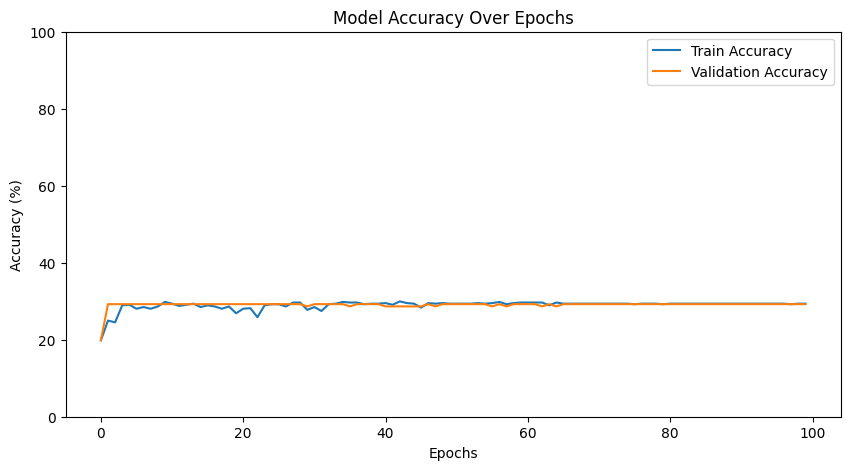

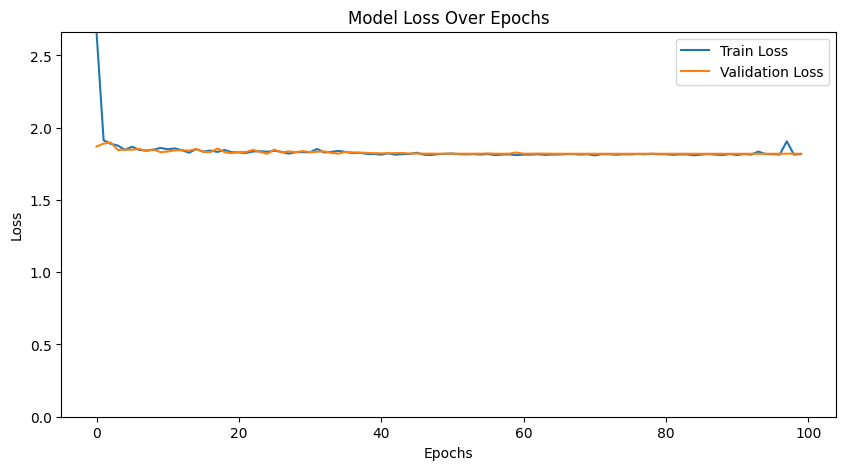

In [12]:

train_acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]


train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set Y-axis from 0 to 100
plt.legend()
plt.title("Model Accuracy Over Epochs")

plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_loss), max(val_loss)))  # Loss usually varies, keeping dynamic scaling
plt.legend()
plt.title("Model Loss Over Epochs")

plt.show()
